<a href="https://colab.research.google.com/github/GusRaymundi/PDI/blob/main/LAB1_Amostragem_Quantiza%C3%A7%C3%A3o_Interpola%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB1 — Amostragem, Quantização, Resolução e Interpolação

Disciplina: **Processamento Digital de Imagens (PDI)**  - UFPel  
Professor: **Guilherme Corrêa**  

Este notebook introduz e pratica os conceitos de **amostragem espacial**, **quantização**, **resolução** e **interpolação**.

**Objetivos**
- Carregar e visualizar imagens em escala de cinza.
- Aplicar **amostragem** (redução da resolução espacial) com e sem anti-aliasing.
- Aplicar **quantização** (redução do número de níveis/bit-depth) e avaliar distorção (PSNR).
- Implementar **interpolação** por **vizinho mais próximo** e **bilinear**; usar **bicúbica** como referência.
- Discutir a relação entre **resolução**, **amostragem** e **interpolação**.

## 0) Ambiente e bibliotecas
Se estiver no Colab, rode a célula de instalação uma única vez.

In [ ]:
# Se necessário no Colab, descomente a linha abaixo:
#!pip -q install numpy matplotlib scikit-image imageio

In [ ]:
import os, math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_ubyte
from skimage.transform import resize
from skimage import data
from skimage.transform import resize as sk_resize

os.makedirs('data', exist_ok=True)
plt.rcParams['figure.dpi'] = 120

## 1) Utilitários
- Leitura sempre em **grayscale** (2D) quando desejado.
- Cálculo de **PSNR** para avaliar perda de qualidade devido à quantização e reamostragem.
- Visualização lado a lado.

In [ ]:
def read_gray(path):
    img = io.imread(path)
    if img.ndim == 3:
        img = color.rgb2gray(img)  # float64 [0,1]
    img = img.astype(np.float32)   # passa para float32
    return img

def psnr(x, y, data_range=1.0):  # calcula a qualidade da imagem em comparação com outra
    x = x.astype(np.float32)
    y = y.astype(np.float32)
    mse = np.mean((x - y)**2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(data_range) - 10 * np.log10(mse)

def show2(a, b, titles=("A","B"), cmaps=('gray','gray')):
    fig, axs = plt.subplots(1,2, figsize=(8,3))
    axs[0].imshow(a, cmap=cmaps[0]); axs[0].set_title(titles[0]); axs[0].axis('off')
    axs[1].imshow(b, cmap=cmaps[1]); axs[1].set_title(titles[1]); axs[1].axis('off')
    plt.show()

## 2) Dados de exemplo
Usaremos `camera` como imagem base (grayscale).

In [ ]:
img0 = data.camera().astype(np.float32) / 255.0
io.imsave('data/camera.png', img_as_ubyte(img0))
plt.imshow(img0, cmap='gray'); plt.title('camera [0..1]'); plt.axis('off'); plt.show()
print('shape:', img0.shape, 'dtype:', img0.dtype)

## 3) Amostragem (downsampling) e anti-aliasing
A redução de resolução pode causar **aliasing**. Uma prática comum é **suavizar** (filtro passa-baixas) antes de dizimar.

Abaixo implementamos downsampling simples e com anti-aliasing (Gaussiano).

In [ ]:
from scipy.ndimage import gaussian_filter

def downsample(img, factor, anti_alias=False, sigma=1.0):
    x = img
    if anti_alias:
        x = gaussian_filter(x, sigma=sigma)
    out = x[::factor, ::factor]
    return out

small_na = downsample(img0, factor=4, anti_alias=False)
small_aa = downsample(img0, factor=4, anti_alias=True, sigma=1.0)
show2(small_na, small_aa, ("Sem AA (×1/4)", "Com AA (×1/4)"))

### **Exercício A** — Downsampling e anti-aliasing
1. Experimente `factor = 2, 4, 8` e valores de `sigma` diferentes (ex.: 0.5, 1.0, 1.5).

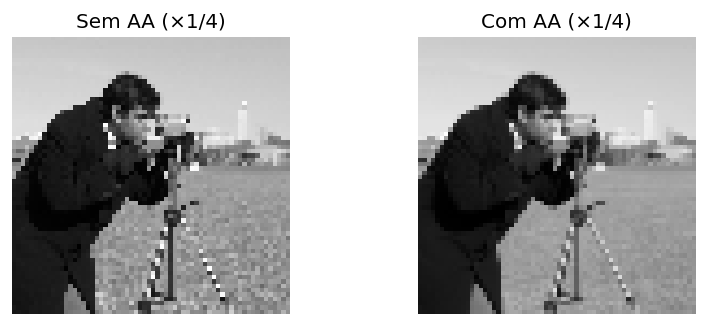

In [99]:
from scipy.ndimage import gaussian_filter

def downsample(img, factor, anti_alias=False, sigma=1.0):
    x = img
    if anti_alias:
        x = gaussian_filter(x, sigma=sigma)
    out = x[::factor, ::factor]
    return out

small_na = downsample(img0, factor=8, anti_alias=False)
small_aa = downsample(img0, factor=8, anti_alias=True, sigma=1.5)
show2(small_na, small_aa, ("Sem AA (×1/4)", "Com AA (×1/4)"))

## 4) Quantização (redução de níveis / bit-depth)
A quantização reduz o número de níveis radiométricos. Testaremos **quantização uniforme** e avaliaremos **PSNR**.

In [ ]:
def quantize_uniform(img0, bits=4):
    levels = 2 ** bits
    # mapeia [0,1] para [0, levels-1], arredonda e volta para [0,1]
    q = np.round(img0 * (levels - 1)) / (levels - 1)
    return q.astype(np.float32)

q2 = quantize_uniform(img0, bits=2)
q4 = quantize_uniform(img0, bits=4)
q6 = quantize_uniform(img0, bits=6)

fig, axs = plt.subplots(1,3, figsize=(11,3))
for ax, im, b in zip(axs, [q2, q4, q6], [2,4,6]):
    ax.imshow(im, cmap='gray'); ax.set_title(f'{b} bits\nPSNR={psnr(img0, im):.2f} dB'); ax.axis('off')
plt.show()

### **Exercício B** — Posteirização
1. Crie uma função que **plote o histograma** de intensidades da imagem quantizada.
2. Compare visualmente quantizações com **2, 3, 4, 6 e 8 bits**.

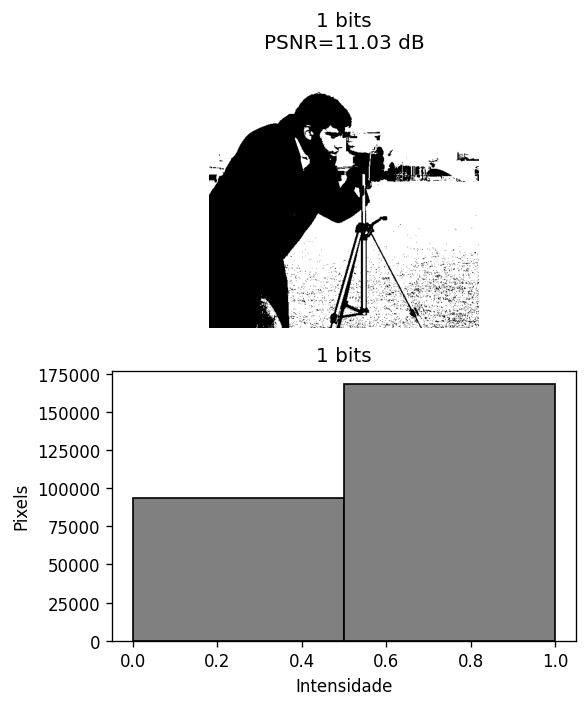

In [76]:
b = 1
q_img = quantize_uniform(img0, bits= b)

fig, axs = plt.subplots(2, 1, figsize=(5, 6))

axs[0].imshow(q_img, cmap='gray')
axs[0].set_title(f'{b} bits\nPSNR={psnr(img0, q_img):.2f} dB')
axs[0].axis('off')

#histograma
plot_histogram(axs[1], q_img, bits= b)

plt.tight_layout()
plt.show()


## 5) Interpolação — NN e Bilinear
A seguir, reimplementamos o interpoladores de **vizinho mais próximo** e **bilinear** para praticar o mapeamento de coordenadas.

In [ ]:
def resize_nn(img, sx, sy):
    h_in, w_in = img.shape
    h_out = int(round(h_in * sy))
    w_out = int(round(w_in * sx))
    out = np.zeros((h_out, w_out), dtype=img.dtype)
    ys = np.arange(h_out)
    xs = np.arange(w_out)
    y_src = (ys + 0.5) / sy - 0.5
    x_src = (xs + 0.5) / sx - 0.5
    y_nn = np.clip(np.round(y_src).astype(int), 0, h_in - 1)
    x_nn = np.clip(np.round(x_src).astype(int), 0, w_in - 1)
    for j_out, j_in in enumerate(y_nn):
        out[j_out, :] = img[j_in, x_nn]
    return out

In [ ]:
def resize_bilinear(img, sx, sy):
    h_in, w_in = img.shape
    h_out = int(round(h_in * sy))
    w_out = int(round(w_in * sx))
    ys = np.arange(h_out)
    xs = np.arange(w_out)
    y_src = (ys + 0.5) / sy - 0.5
    x_src = (xs + 0.5) / sx - 0.5
    y0 = np.floor(y_src).astype(int)
    x0 = np.floor(x_src).astype(int)
    y1 = np.clip(y0 + 1, 0, h_in - 1)
    x1 = np.clip(x0 + 1, 0, w_in - 1)
    wy = (y_src - y0).reshape(-1, 1)
    wx = (x_src - x0).reshape(1, -1)
    y0 = np.clip(y0, 0, h_in - 1)
    x0 = np.clip(x0, 0, w_in - 1)
    I00 = img[y0[:, None], x0[None, :]]
    I01 = img[y0[:, None], x1[None, :]]
    I10 = img[y1[:, None], x0[None, :]]
    I11 = img[y1[:, None], x1[None, :]]
    out = (1 - wy) * (1 - wx) * I00 + (1 - wy) * wx * I01 + wy * (1 - wx) * I10 + wy * wx * I11
    return out.astype(np.float32)

### **Exercício C** — Interpoladores
1. Crie uma função `redimensionar(img, tipo, sx, sy)` que use `resize_nn` se `tipo==1` e `resize_bilinear` se `tipo==2`. A função deve receber uma imagem `img` e a escala de redimensionamento no eixo horizontal e vertical `sx` e `sy`.
2. Realize o **downsample** de uma imagem original e depois faça a interpolação NN e bilinear de volta para a sua resolução original.
3. Use também a função pronta `skimage.transform.resize(..., order=3)` para a interpolação **bicúbica** (chamada abaixo).
4. Compare visualmente os resultados das interpolações NN, bilinear e bicúbica para ampliações **2×, 3× e 4×**. Discuta aliasing e suavização.
5. Calcule o **PSNR** para as imagens interpoladas, usando como referência para cálculo de qualidade a imagem original.



**Chamada da interpolação bicúbica:**

sk_resize(image, (int(height*sx), int(width*sy)), order=3, anti_aliasing=True, preserve_range=True).astype(np.float32)

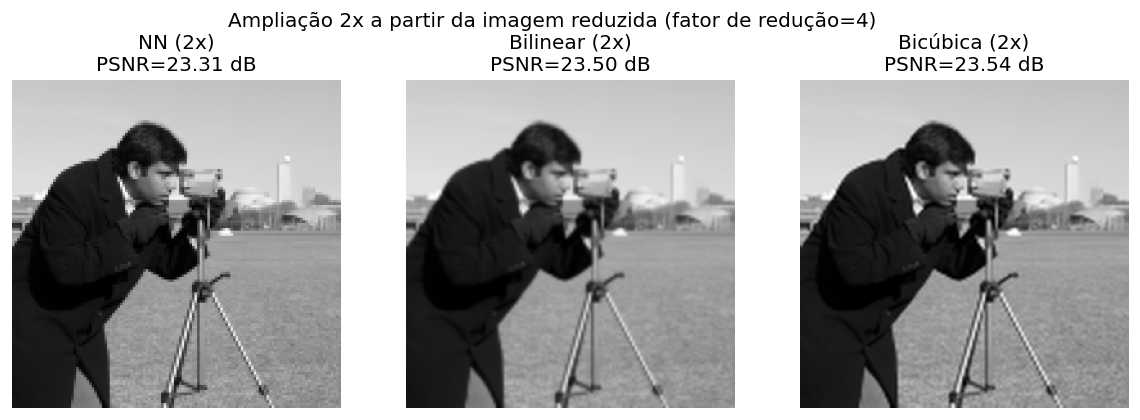

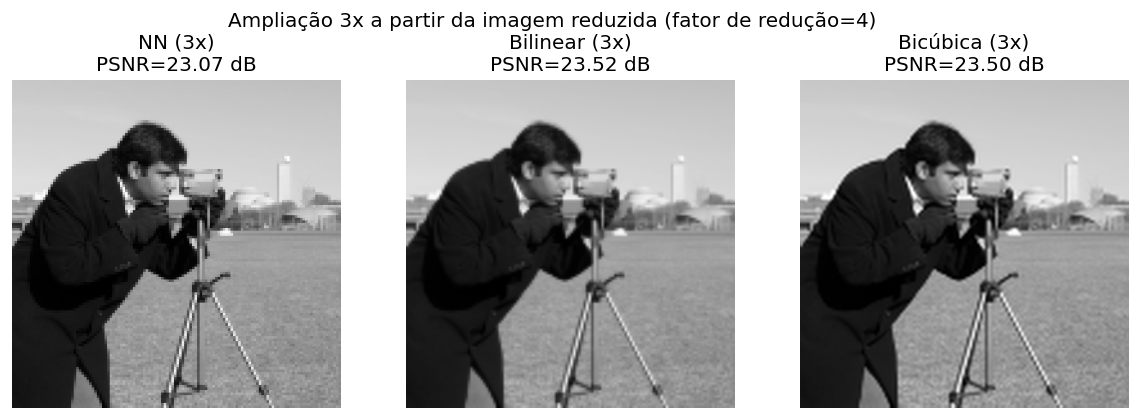

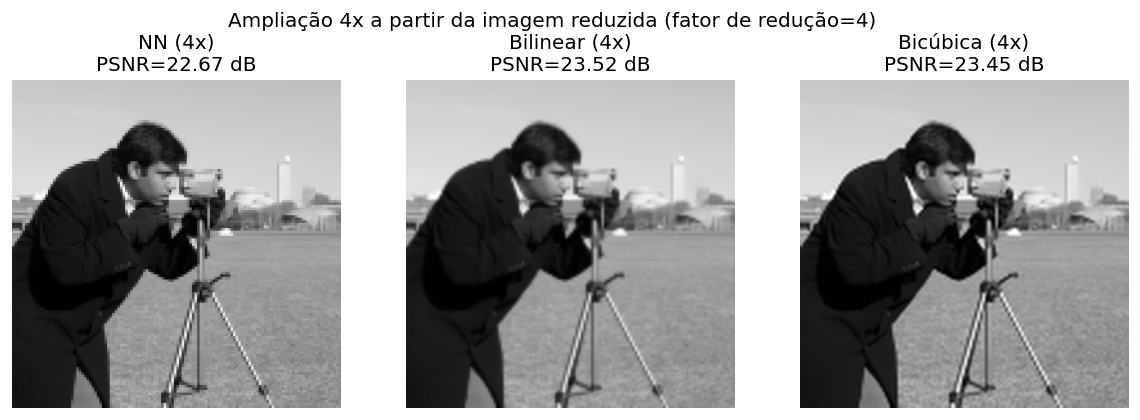

In [101]:
def resize_nn(img, sx, sy):
    h_in, w_in = img.shape
    h_out = int(round(h_in * sy))
    w_out = int(round(w_in * sx))
    out = np.zeros((h_out, w_out), dtype=img.dtype)
    ys = np.arange(h_out)
    xs = np.arange(w_out)
    y_src = (ys + 0.5) / sy - 0.5
    x_src = (xs + 0.5) / sx - 0.5
    y_nn = np.clip(np.round(y_src).astype(int), 0, h_in - 1)
    x_nn = np.clip(np.round(x_src).astype(int), 0, w_in - 1)
    for j_out, j_in in enumerate(y_nn):
        out[j_out, :] = img[j_in, x_nn]
    return out

def resize_bilinear(img, sx, sy):
    h_in, w_in = img.shape
    h_out = int(round(h_in * sy))
    w_out = int(round(w_in * sx))
    ys = np.arange(h_out)
    xs = np.arange(w_out)
    y_src = (ys + 0.5) / sy - 0.5
    x_src = (xs + 0.5) / sx - 0.5
    y0 = np.floor(y_src).astype(int)
    x0 = np.floor(x_src).astype(int)
    y1 = np.clip(y0 + 1, 0, h_in - 1)
    x1 = np.clip(x0 + 1, 0, w_in - 1)
    wy = (y_src - y0).reshape(-1, 1)
    wx = (x_src - x0).reshape(1, -1)
    y0 = np.clip(y0, 0, h_in - 1)
    x0 = np.clip(x0, 0, w_in - 1)
    I00 = img[y0[:, None], x0[None, :]]
    I01 = img[y0[:, None], x1[None, :]]
    I10 = img[y1[:, None], x0[None, :]]
    I11 = img[y1[:, None], x1[None, :]]
    out = (1 - wy) * (1 - wx) * I00 + (1 - wy) * wx * I01 + wy * (1 - wx) * I10 + wy * wx * I11
    return out.astype(np.float32)

img0 = img_as_float(data.camera()).astype(np.float32)

def redimensionar(img, tipo, sx, sy):
    if tipo == 1:
        out = resize_nn(img, sx, sy)
    elif tipo == 2:
        out = resize_bilinear(img, sx, sy)
    else:
        raise ValueError("Tipo deve ser 1 (NN) ou 2 (Bilinear)")
    return out

# Fator de redução (downsample)
fator_reducao = 4

# Reduzir a imagem original
img_downsampled = downsample(img0, factor=fator_reducao, anti_alias=True)

# Fatores de ampliação para comparar
fatores_ampliacao = [2, 3, 4]

for fator_ampliacao in fatores_ampliacao:
    sx = sy = fator_ampliacao

    # Interpolação NN
    img_nn = redimensionar(img_downsampled, tipo=1, sx=sx, sy=sy)

    # Interpolação Bilinear
    img_bilinear = redimensionar(img_downsampled, tipo=2, sx=sx, sy=sy)

    # Interpolação Bicúbica
    h_out = int(round(img_downsampled.shape[0] * sy))
    w_out = int(round(img_downsampled.shape[1] * sx))
    img_bicubic = sk_resize(
        img_downsampled,
        (h_out, w_out),
        order=3,
        anti_aliasing=True,
        preserve_range=True
    ).astype(np.float32)

    # Calcular PSNR
    # Redimensionar imagens ampliadas de volta para o tamanho original para o cálculo do PSNR
    img_nn_resized = sk_resize(img_nn, img0.shape, anti_aliasing=True, preserve_range=True).astype(np.float32)
    img_bilinear_resized = sk_resize(img_bilinear, img0.shape, anti_aliasing=True, preserve_range=True).astype(np.float32)
    img_bicubic_resized = sk_resize(img_bicubic, img0.shape, anti_aliasing=True, preserve_range=True).astype(np.float32)

    psnr_nn = psnr(img0, img_nn_resized)
    psnr_bilinear = psnr(img0, img_bilinear_resized)
    psnr_bicubic = psnr(img0, img_bicubic_resized)

    # Exibir resultados
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img_nn, cmap='gray')
    axs[0].set_title(f'NN ({fator_ampliacao}x)\nPSNR={psnr_nn:.2f} dB')
    axs[0].axis('off')

    axs[1].imshow(img_bilinear, cmap='gray')
    axs[1].set_title(f'Bilinear ({fator_ampliacao}x)\nPSNR={psnr_bilinear:.2f} dB')
    axs[1].axis('off')

    axs[2].imshow(img_bicubic, cmap='gray')
    axs[2].set_title(f'Bicúbica ({fator_ampliacao}x)\nPSNR={psnr_bicubic:.2f} dB')
    axs[2].axis('off')

    plt.suptitle(f'Ampliação {fator_ampliacao}x a partir da imagem reduzida (fator de redução={fator_reducao})')
    plt.show()
